# Calculating image quality thresholds

This notebook focuses on calculating thresholds for different image quality levels. These are based on a grading system used by paleontologist Isaak Eijkelboom. He graded 100 images containing fossils. These were submitted by citizen scientists. 
These 100 images are used in this notebook to connect the subjective grading (1 to 5) with calculated image quality metrics. The goal is to form a more comprehensive grading system, that can be used later in a prototype. That prototype guides users to take images with better image quality.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
# Create DataFrame with only relevant columns

df = pd.read_csv("expert_graded.csv", sep=';')
df = df[['image_id', 'Lighting', 'Sharpness', 
         'Number of and relevancy of angles photographed', 
         'Contrast with background', 'Scale present']]

print("Loaded CSV with columns:", df.columns.tolist())
print("Number of rows:", len(df))

df.head()


Loaded CSV with columns: ['image_id', 'Lighting', 'Sharpness', 'Number of and relevancy of angles photographed', 'Contrast with background', 'Scale present']
Number of rows: 100


,image_id,Lighting,Sharpness,Number of and relevancy of angles photographed,Contrast with background,Scale present
0,i33818,4,4,3,3,5
1,i33796,3,3,5,5,5
2,i33784,3,3,1,5,5
3,i33779,3,3,3,5,5
4,i33708,3,4,2,5,5


In [19]:
# Image folder and loader 
image_folder = "images_isaak"

def load_image(image_id):
    # filenames are like oer_NS_i3253.jpg
    pattern = f"oer_NS_{image_id}.jpg"
    path = os.path.join(image_folder, pattern)
    if os.path.exists(path):
        return cv2.imread(path)
    else:
        print(f"Image not found: {path}")
        return None

In [20]:
# Image Quality Metric Functions 
def lighting_metric(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray), np.std(gray)

def sharpness_metric(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def contrast_metric(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray.std()

def scale_metric(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    return edge_density

In [21]:
# Compute metrics for all images

metrics = []

for _, row in df.iterrows():
    image_id = str(row['image_id']).strip()
    img = load_image(image_id)
    if img is None:
        continue
    
    light_mean, light_std = lighting_metric(img)
    sharp = sharpness_metric(img)
    contrast = contrast_metric(img)
    scale = scale_metric(img)
    
    metrics.append({
        'image_id': image_id,
        'lighting_mean': light_mean,
        'lighting_std': light_std,
        'sharpness_metric': sharp,
        'contrast_metric': contrast,
        'scale_metric': scale
    })

metrics_df = pd.DataFrame(metrics)

# ==== 5. Merge expert ratings with computed metrics ====
merged = pd.merge(df, metrics_df, on='image_id', how='inner')
print("Merged shape:", merged.shape)
print("Loaded:", merged.shape, "rows")
merged.head()


Merged shape: (100, 11)
Loaded: (100, 11) rows


,image_id,Lighting,Sharpness,Number of and relevancy of angles photographed,Contrast with background,Scale present,lighting_mean,lighting_std,sharpness_metric,contrast_metric,scale_metric
0,i33818,4,4,3,3,5,199.526109,55.118036,624.339981,55.118036,0.061137
1,i33796,3,3,5,5,5,94.970927,38.251232,2152.783164,38.251232,0.129575
2,i33784,3,3,1,5,5,186.595302,51.299862,716.106263,51.299862,0.056016
3,i33779,3,3,3,5,5,173.850505,61.480341,1178.601512,61.480341,0.076758
4,i33708,3,4,2,5,5,183.048188,64.480048,476.927963,64.480048,0.051199


In [22]:
import numpy as np

# Define a function to find outliers using z-score
def find_outliers_zscore(df, column, threshold=3):
    mean_val = df[column].mean()
    std_val = df[column].std()
    z_scores = (df[column] - mean_val) / std_val
    return df[np.abs(z_scores) > threshold]

# Check outliers for each metric
metrics_columns = ['lighting_mean', 'lighting_std', 'sharpness_metric', 'contrast_metric', 'scale_metric']

for col in metrics_columns:
    outliers = find_outliers_zscore(merged, col)
    if not outliers.empty:
        print(f"Outliers detected in {col}:")
        print(outliers[['image_id', col]])
        # Remove outliers if extremely different
        merged = merged.drop(outliers.index)

print("After removing outliers, shape:", merged.shape)


Outliers detected in sharpness_metric:
   image_id  sharpness_metric
14   i33472       8571.249605
71   i31786       5630.617188
Outliers detected in scale_metric:
   image_id  scale_metric
24   i33270      0.299110
50   i32389      0.303431
67   i31852      0.282745
73   i31745      0.298988
After removing outliers, shape: (94, 11)


In [23]:
# Helper functions

def median_midpoint_thresholds(df, continuous_col, label_col):
    medians = df.groupby(label_col)[continuous_col].median().sort_index()
    # Use positional indexing (iloc) because medians' index labels may not start at 0.
    if len(medians) < 2:
        return medians, []
    thresholds = [(medians.iloc[i] + medians.iloc[i+1]) / 2 for i in range(len(medians)-1)]
    return medians, thresholds

def apply_thresholds(value, thresholds):
    for i, t in enumerate(thresholds):
        if value <= t:
            return i + 1
    return len(thresholds) + 1

def dt_thresholds(df, cont_col, label_col):
    X = df[[cont_col]].values
    y = df[label_col].values
    dt = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
    dt.fit(X, y)
    thr = sorted([v for v in dt.tree_.threshold if v != -2])
    preds = dt.predict(X)
    return dt, thr, preds

def plot_dist_with_thresholds(df, cont_col, label_col, thresholds, title):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=label_col, y=cont_col, data=df, order=[1, 2, 3, 4, 5])
    for t in thresholds:
        plt.axhline(t, color='red', linestyle='--')
    plt.title(title)
    plt.show()


===== LIGHTING_MEAN vs LIGHTING_LABEL =====
Falling back to percentile thresholds: [np.float64(131.76395376029762), np.float64(150.47297688014882), np.float64(164.16295243157055), np.float64(182.3934047302684)]
Median midpoints: {2: 144.28686420409247, 3: 153.87310124900347, 4: 167.04771990433164, 5: 152.98395163433432}
Thresholds used: [np.float64(131.76395376029762), np.float64(150.47297688014882), np.float64(164.16295243157055), np.float64(182.3934047302684)]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.26      0.42      0.32        12
           3       0.39      0.14      0.20        51
           4       0.53      0.38      0.44        26
           5       0.05      0.20      0.08         5

    accuracy                           0.24        94
   macro avg       0.25      0.23      0.21        94
weighted avg       0.39      0.24      0.28        94



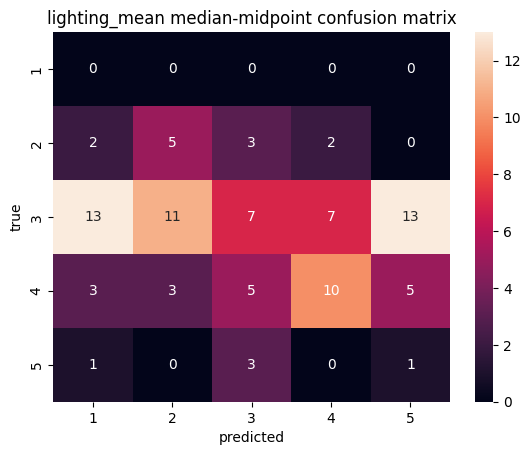

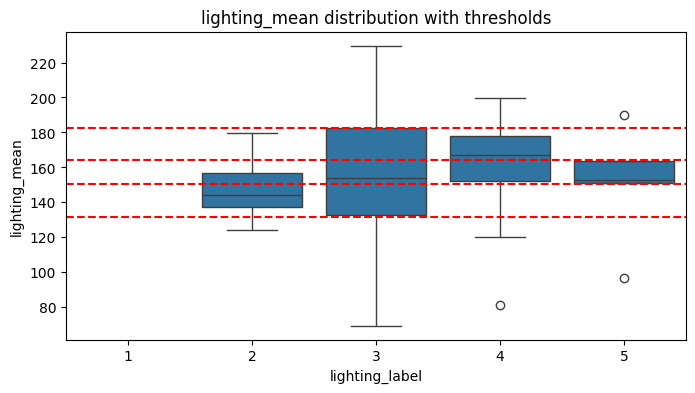

Decision tree thresholds: [np.float64(151.426513671875), np.float64(155.70542907714844), np.float64(164.97052764892578), np.float64(180.4318389892578)]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        12
           3       0.62      0.88      0.73        51
           4       0.64      0.54      0.58        26
           5       0.00      0.00      0.00         5

    accuracy                           0.63        94
   macro avg       0.25      0.28      0.26        94
weighted avg       0.52      0.63      0.56        94



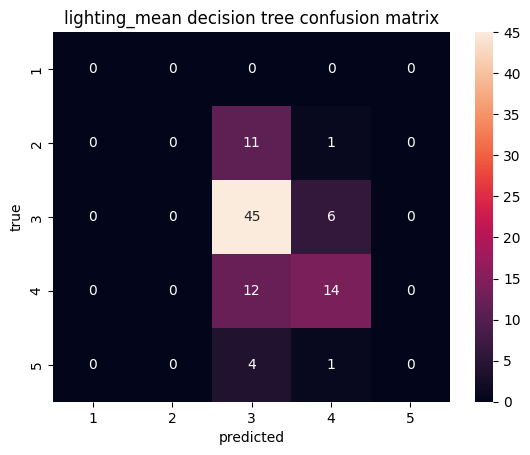


===== SHARPNESS_METRIC vs SHARPNESS_LABEL =====
Falling back to percentile thresholds: [np.float64(156.27923255745463), np.float64(300.3745212591177), np.float64(458.40354170433267), np.float64(822.6026575437147)]
Median midpoints: {2: 167.40533976625204, 3: 297.8597286403219, 4: 441.81711425219214, 5: 144.7363613796629}
Thresholds used: [np.float64(156.27923255745463), np.float64(300.3745212591177), np.float64(458.40354170433267), np.float64(822.6026575437147)]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.16      0.75      0.26         4
           3       0.28      0.16      0.20        31
           4       0.74      0.25      0.37        56
           5       0.00      0.00      0.00         3

    accuracy                           0.23        94
   macro avg       0.23      0.23      0.17        94
weighted avg       0.54      0.23      0.30        94



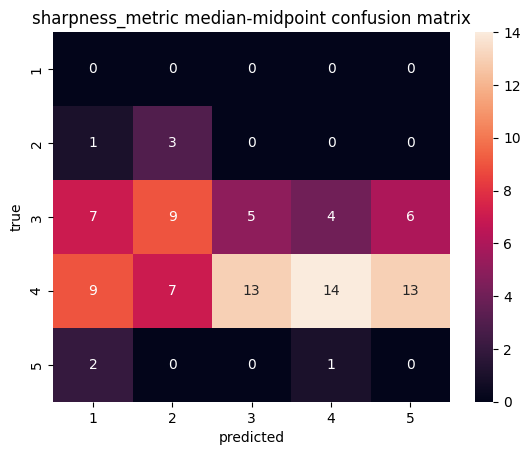

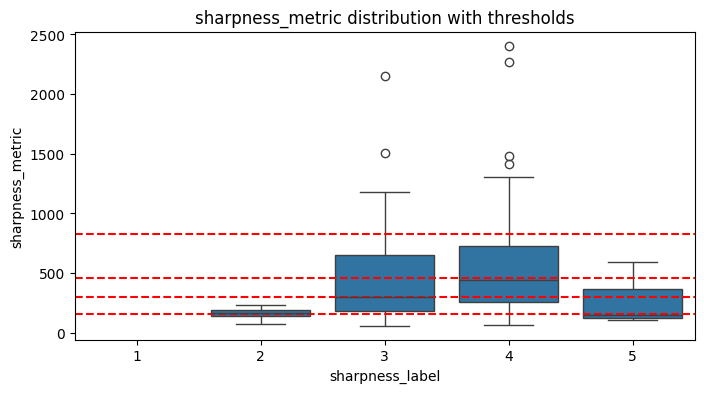

Decision tree thresholds: [np.float64(186.0257568359375), np.float64(232.21768951416016), np.float64(235.72533416748047), np.float64(575.0833435058594)]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.25      0.40         4
           3       1.00      0.23      0.37        31
           4       0.65      1.00      0.79        56
           5       0.00      0.00      0.00         3

    accuracy                           0.68        94
   macro avg       0.53      0.30      0.31        94
weighted avg       0.76      0.68      0.61        94



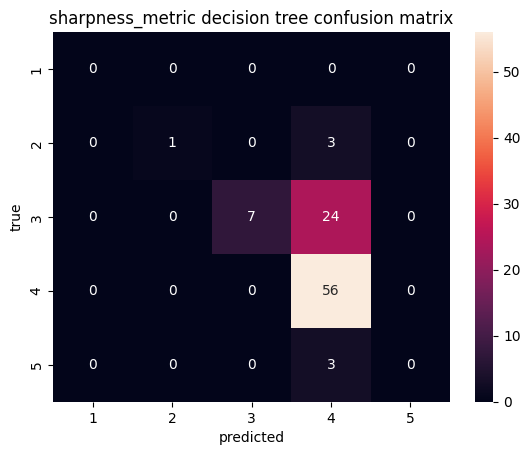


===== CONTRAST_METRIC vs CONTRAST_LABEL =====
Falling back to percentile thresholds: [np.float64(49.268804590875746), np.float64(58.53861922038986), np.float64(63.891490146132185), np.float64(71.79283639694356)]
Median midpoints: {1: 51.10506360098379, 3: 61.64805884847349, 5: 61.55252887556627}
Thresholds used: [np.float64(49.268804590875746), np.float64(58.53861922038986), np.float64(63.891490146132185), np.float64(71.79283639694356)]
              precision    recall  f1-score   support

           1       0.16      0.43      0.23         7
           2       0.00      0.00      0.00         0
           3       0.22      0.19      0.21        21
           4       0.00      0.00      0.00         0
           5       0.74      0.21      0.33        66

    accuracy                           0.22        94
   macro avg       0.22      0.17      0.15        94
weighted avg       0.58      0.22      0.29        94



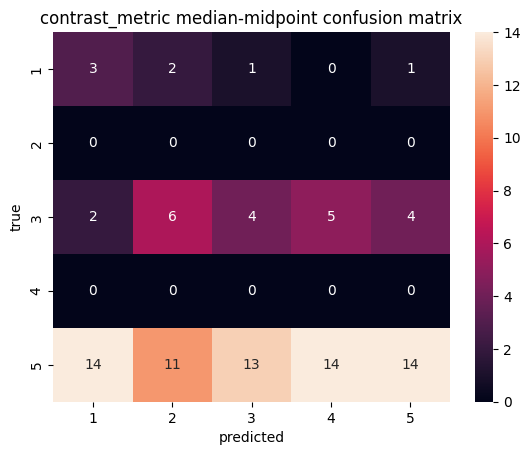

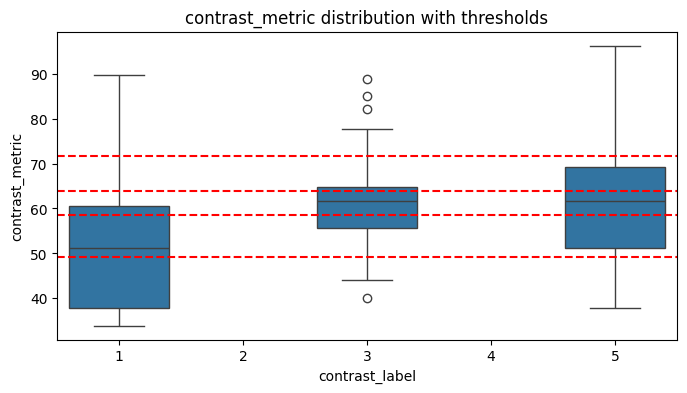

Decision tree thresholds: [np.float64(36.17853546142578), np.float64(63.66232109069824), np.float64(64.95207214355469), np.float64(81.2933120727539)]
              precision    recall  f1-score   support

           1       1.00      0.29      0.44         7
           2       0.00      0.00      0.00         0
           3       0.64      0.33      0.44        21
           4       0.00      0.00      0.00         0
           5       0.78      0.95      0.86        66

    accuracy                           0.77        94
   macro avg       0.48      0.31      0.35        94
weighted avg       0.76      0.77      0.73        94



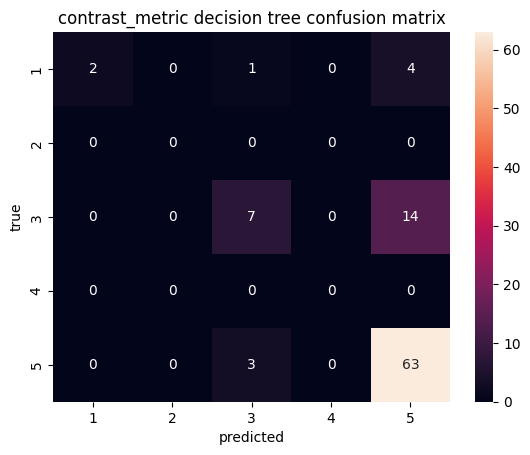

In [24]:
results = {}

# Ensure expected label columns exist in `merged`.
# Map the existing expert columns to the lowercase label names the rest of the code expects.
label_map = {
    'lighting_label': ['Lighting', 'lighting', 'lighting_label'],
    'sharpness_label': ['Sharpness', 'sharpness', 'sharpness_label'],
    'contrast_label': ['Contrast with background', 'Contrast', 'contrast', 'contrast_label']
}

for target, candidates in label_map.items():
    for c in candidates:
        if c in merged.columns:
            merged[target] = merged[c]
            break
    else:
        merged[target] = np.nan
        print(f"Warning: could not find a source column for '{target}'; filled with NaN")

for metric, label in [
    ('lighting_mean', 'lighting_label'),
    ('sharpness_metric', 'sharpness_label'),
    ('contrast_metric', 'contrast_label')
]:
    print(f"\n===== {metric.upper()} vs {label.upper()} =====")

    # compute median-midpoint thresholds
    med, thr = median_midpoint_thresholds(merged, metric, label)

    # If median method produced too few thresholds (e.g. small sample / missing labels),
    # fall back to percentile-based thresholds (20/40/60/80 -> 4 thresholds for 5 bins)
    if not thr or len(thr) < 4:
        vals = merged[metric].dropna().values
        if len(vals) >= 5:
            thr = list(np.percentile(vals, [20, 40, 60, 80]))
            print("Falling back to percentile thresholds:", thr)
        else:
            thr = []  # keep empty -> apply_thresholds will map all to category 1
            print("Insufficient data for robust thresholds; leaving thr empty")

    # apply median-based predictions (or percentile fallback)
    pred_col_med = f'{metric}_pred_med'
    if thr:
        merged.loc[:, pred_col_med] = merged[metric].apply(lambda x: apply_thresholds(x, thr) if not pd.isna(x) else np.nan)
    else:
        # if thr empty, map using simple quantiles to avoid errors
        merged.loc[:, pred_col_med] = merged[metric].rank(method='min', na_option='keep').apply(
            lambda r: int(np.ceil((r / merged[metric].rank(method='min').max()) * 5)) if not pd.isna(r) else np.nan
        )

    print("Median midpoints:", med.to_dict() if hasattr(med, "to_dict") else dict(med))
    print("Thresholds used:", thr)

    # prepare for classification report: drop rows with NaN in label or prediction
    try:
        y_true = merged[label].astype(int)
    except Exception:
        y_true = merged[label]

    mask = y_true.notna() & merged[pred_col_med].notna()
    if mask.sum() == 0:
        print("No valid rows for classification report (median method).")
    else:
        y_true_mask = y_true[mask].astype(int)
        y_pred_mask = merged.loc[mask, pred_col_med].astype(int)
        labels_list = [1, 2, 3, 4, 5]
        print(classification_report(y_true_mask, y_pred_mask, labels=labels_list, zero_division=0))
        cm = confusion_matrix(y_true_mask, y_pred_mask, labels=labels_list)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_list, yticklabels=labels_list)
        plt.title(f'{metric} median-midpoint confusion matrix')
        plt.xlabel('predicted')
        plt.ylabel('true')
        plt.show()

    plot_dist_with_thresholds(merged, metric, label, thr, f'{metric} distribution with thresholds')

    # Decision tree thresholds 
    try:
        dt, thr_dt, preds_dt = dt_thresholds(merged, metric, label)
        merged.loc[:, f'{metric}_pred_dt'] = preds_dt
        print("Decision tree thresholds:", thr_dt)

        # classification report and confusion matrix for DT preds
        mask_dt = y_true.notna() & merged[f'{metric}_pred_dt'].notna()
        if mask_dt.sum() > 0:
            y_true_dt = y_true[mask_dt].astype(int)
            y_pred_dt = merged.loc[mask_dt, f'{metric}_pred_dt'].astype(int)
            print(classification_report(y_true_dt, y_pred_dt, labels=labels_list, zero_division=0))
            cm_dt = confusion_matrix(y_true_dt, y_pred_dt, labels=labels_list)
            sns.heatmap(cm_dt, annot=True, fmt='d', xticklabels=labels_list, yticklabels=labels_list)
            plt.title(f'{metric} decision tree confusion matrix')
            plt.xlabel('predicted')
            plt.ylabel('true')
            plt.show()
        else:
            print("No valid rows for classification report (decision tree).")

    except Exception as e:
        print(f"Decision tree step skipped for {metric} (error: {e})")
        dt = None
        thr_dt = []
        preds_dt = []

    results[metric] = {
        'median_thresholds': thr,
        'dt_thresholds': thr_dt,
        'median_medians': med.to_dict() if hasattr(med, "to_dict") else dict(med)
    }

In [25]:
# Save thresholds
import json
with open('image_quality_thresholds.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\nSaved threshold results to image_quality_thresholds.json")


Saved threshold results to image_quality_thresholds.json


In [26]:
image_folder = "images_isaak"
df = merged.copy()

# Load thresholds from JSON (fallback to hardcoded if missing)

thresholds_file = "image_quality_thresholds.json"

if os.path.exists(thresholds_file):
    with open(thresholds_file, 'r') as fh:
        thresholds = json.load(fh)
    print(f"Loaded thresholds from {thresholds_file}")
else:
    print(f"Threshold file not found: {thresholds_file}, using inline defaults")
    thresholds = {
        "lighting_mean": [130.92, 164.31, 168.96, 180.43],
        "sharpness_metric": [141.52, 186.03, 232.22, 235.72],
        "contrast_metric": [36.18, 51.72, 64.95, 81.29]
    }

# Helper: map a continuous value to a 1–5 category based on thresholds
def to_quality_category(value, th):
    if pd.isna(value):
        return np.nan
    # ensure th is a sequence of thresholds with at least 4 entries
    try:
        if not th or len(th) < 4:
            return np.nan
    except Exception:
        return np.nan
    if value < th[0]:
        return 1
    elif value < th[1]:
        return 2
    elif value < th[2]:
        return 3
    elif value < th[3]:
        return 4
    else:
        return 5
    
# Apply thresholds to assign quality categories 
for metric in ["lighting_mean", "sharpness_metric", "contrast_metric"]:
    raw = thresholds.get(metric, [])
    # extract threshold list if nested dict
    if isinstance(raw, dict):
        th_list = raw.get('dt_thresholds') or raw.get('median_thresholds') or []
    else:
        th_list = raw

    # If threshold list is missing or too short, compute percentile fallback from the data
    if not isinstance(th_list, (list, tuple)) or len(th_list) < 4:
        vals = df[metric].dropna().values
        if len(vals) >= 5:
            th_list = list(np.percentile(vals, [20, 40, 60, 80]))
            print(f"Computed percentile thresholds for {metric}: {th_list}")
        else:
            th_list = []

    pred_col = f"{metric}_pred"
    if th_list:
        df.loc[:, pred_col] = df[metric].apply(lambda x: to_quality_category(x, th_list) if not pd.isna(x) else np.nan)
    else:
        # fallback: map by rank into 1..5 to avoid missing predictions
        ranks = df[metric].rank(method='min', na_option='keep')
        maxr = ranks.max() if ranks.size > 0 else np.nan
        if not pd.isna(maxr) and maxr > 0:
            df.loc[:, pred_col] = ranks.apply(lambda r: int(np.ceil((r / maxr) * 5)) if not pd.isna(r) else np.nan)
        else:
            df.loc[:, pred_col] = np.nan

Loaded thresholds from image_quality_thresholds.json


=== Representative Images by Lighting Quality ===


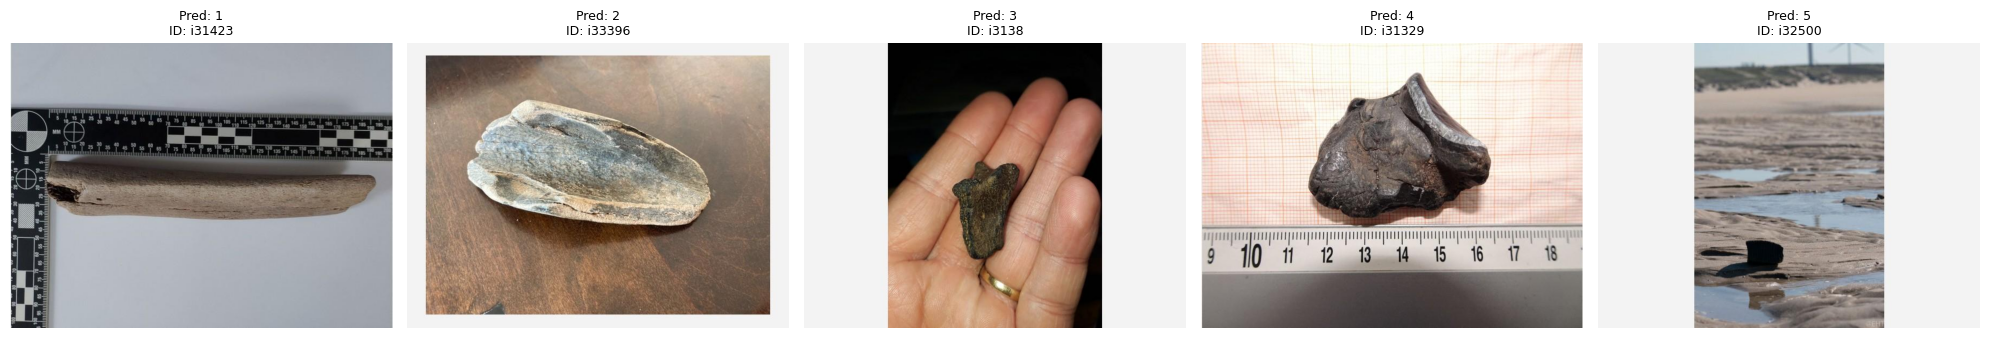

=== Representative Images by Sharpness Quality ===


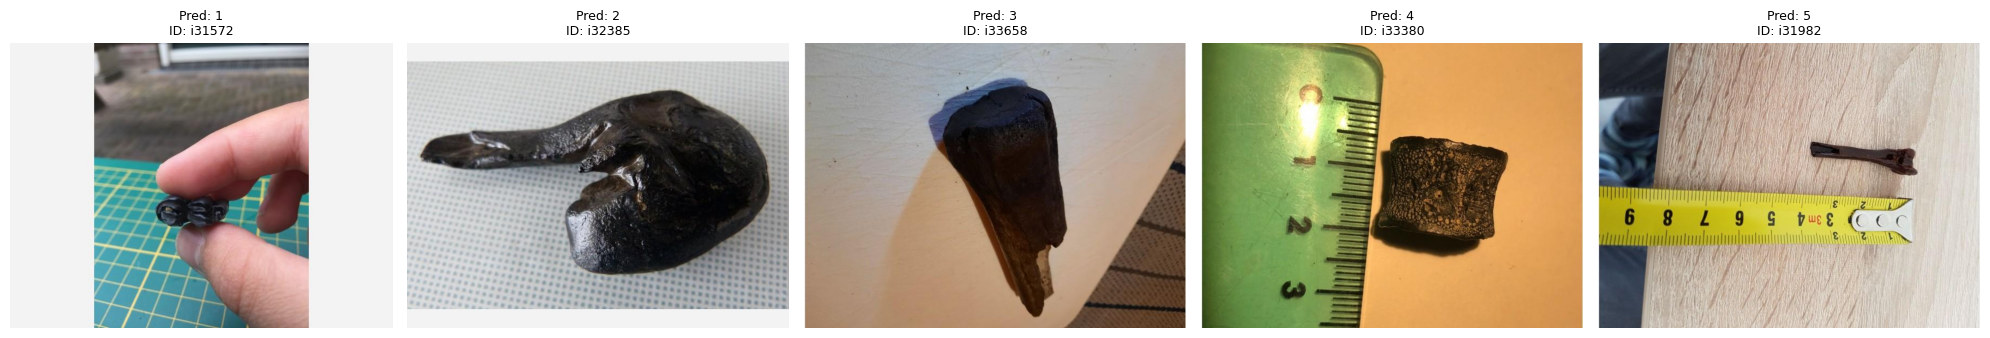

=== Representative Images by Contrast Quality ===


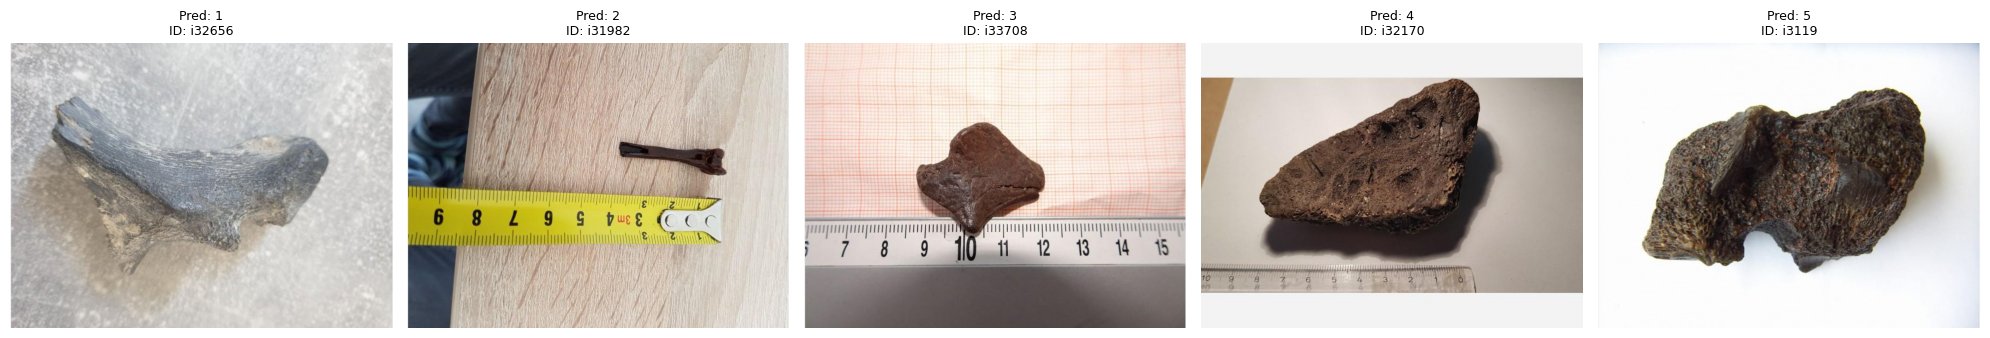

In [27]:

# Show representative examples per quality category
representatives = {}
for metric in ["lighting_mean", "sharpness_metric", "contrast_metric"]:
    reps = []
    pred_col = f"{metric}_pred"
    for q in range(1, 6):
        subset = df.loc[df[pred_col] == q]
        if subset.empty:
            continue
        median_val = subset[metric].median()
        # find index of row closest to median
        idx_closest = (subset[metric] - median_val).abs().idxmin()
        closest = subset.loc[idx_closest].copy()
        reps.append(closest)
    representatives[metric] = reps

# === Visualize representatives (robust display handling) ===
def show_representatives(metric):
    rows = representatives.get(metric, [])
    if not rows:
        print(f"No data for {metric}")
        return

    n = len(rows)
    fig, axes = plt.subplots(1, max(1, n), figsize=(4 * max(1, n), 4), squeeze=False)
    axes = axes.flatten()

    for i, row in enumerate(rows):
        image_id = str(row['image_id']).strip()
        img = load_image(image_id)   # notebook's loader
        if img is None:
            axes[i].set_title(f"Missing\n{image_id}", fontsize=9)
            axes[i].axis('off')
            continue

        # handle different channel numbers and convert BGR->RGB
        if img.ndim == 2:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        pred_label = int(row.get(f"{metric}_pred")) if not pd.isna(row.get(f"{metric}_pred")) else None
        axes[i].set_title(f"Pred: {pred_label}\nID: {image_id}", fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display for each metric
print("=== Representative Images by Lighting Quality ===")
show_representatives("lighting_mean")
print("=== Representative Images by Sharpness Quality ===")
show_representatives("sharpness_metric")
print("=== Representative Images by Contrast Quality ===")
show_representatives("contrast_metric")

# Other metrics: Scale present and number of angles
To grade the presence of a scale, the grading system by Isaak Eijkelboom can be applied directly.
- No scale = Very poor
- Approximate scale (eg. hand) = Poor
- Exact scale (coin) = Good
- Best scale (ruler) = Very good

This can be checked by using machine/deep learning in a prototype. 

The number of angles can be calculated while in the submission process. Again, Eijkelbooms system can be used for inspiration. It is still unclear how the relevancy of the images angle is going to be checked.
- 1 image, not relevant = Very poor
- 1-2 image, somewhat relevant = Poor
- 3+ images, somewhat relevant = Intermediate
- 1-2 images, relevant angles = Good
- 3+ images, relevant angles = Very Good